# Potato Disease: Leaf Image Classificaiton

In [80]:
import tensorflow as tf

In [81]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [82]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [83]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [84]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [85]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [86]:
# 68 batches , each batches containing 32 images
len(dataset)

68

In [87]:
print(dataset.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


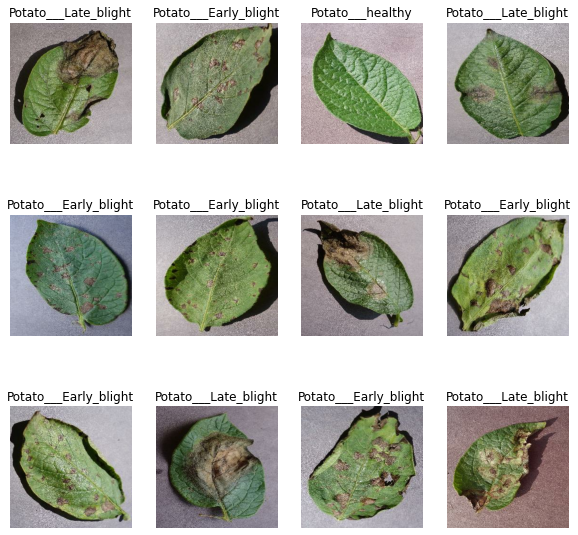

In [88]:
plt.figure(figsize = (10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
#         print(image_batch.shape)
#         print(label_batch.numpy())
    

In [89]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [90]:
train_ds = dataset.take(54)
len(train_ds)

54

In [91]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [92]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [93]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [94]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [95]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [101]:
train_ds , val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [102]:
len(train_ds)

54

In [103]:
len(val_ds)

6

In [104]:
len(test_ds)

8

In [105]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [106]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [107]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
]) 

In [108]:
input_shape = (BATCH_SIZE, IMAGE_SIZE , IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

In [109]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [110]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [111]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 182s 3s/step - loss: 0.8968 - accuracy: 0.5058 - val_loss: 0.8653 - val_accuracy: 0.4583
Epoch 2/10
54/54 [==============================] - 134s 2s/step - loss: 0.7437 - accuracy: 0.6644 - val_loss: 0.6236 - val_accuracy: 0.7240
Epoch 3/10
54/54 [==============================] - 135s 3s/step - loss: 0.4721 - accuracy: 0.8015 - val_loss: 0.3054 - val_accuracy: 0.8542
Epoch 4/10
54/54 [==============================] - 138s 3s/step - loss: 0.3424 - accuracy: 0.8559 - val_loss: 0.2648 - val_accuracy: 0.9219
Epoch 5/10
54/54 [==============================] - 134s 2s/step - loss: 0.3365 - accuracy: 0.8513 - val_loss: 0.3557 - val_accuracy: 0.8490
Epoch 6/10
54/54 [==============================] - 152s 3s/step - loss: 0.2764 - accuracy: 0.8947 - val_loss: 0.2298 - val_accuracy: 0.9271
Epoch 7/10
54/54 [==============================] - 147s 3s/step - loss: 0.2494 - accuracy: 0.9080 - val_loss: 0.2360 - val_accuracy: 0.9219
Epoch 8/10
54

In [112]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 356ms/step - loss: 0.1330 - accuracy: 0.9492


In [113]:
scores

[0.1330128312110901, 0.94921875]

In [114]:
history

In [115]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [116]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


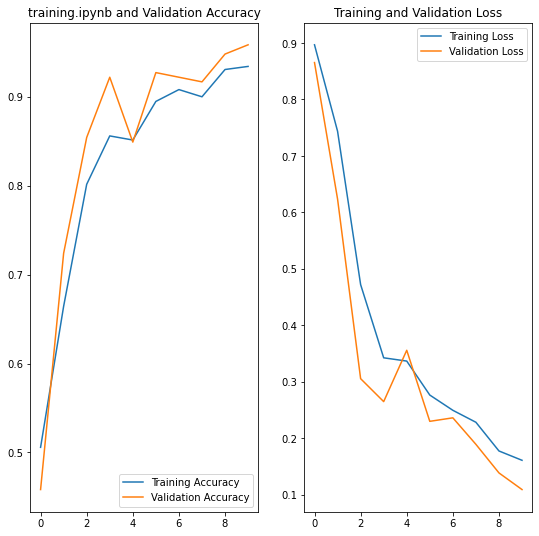

In [118]:
plt.figure(figsize = (9,9))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("training.ipynb and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()


first image to predict
actual label: Potato___healthy
predicted class: Potato___healthy


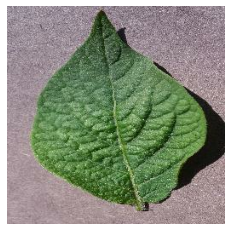

In [119]:
import numpy as np 
for images_batch , labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.axis('off')
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted class:", class_names[np.argmax(batch_prediction[0])])

In [120]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*np.max(predictions[0]),2)
    return predicted_class , confidence

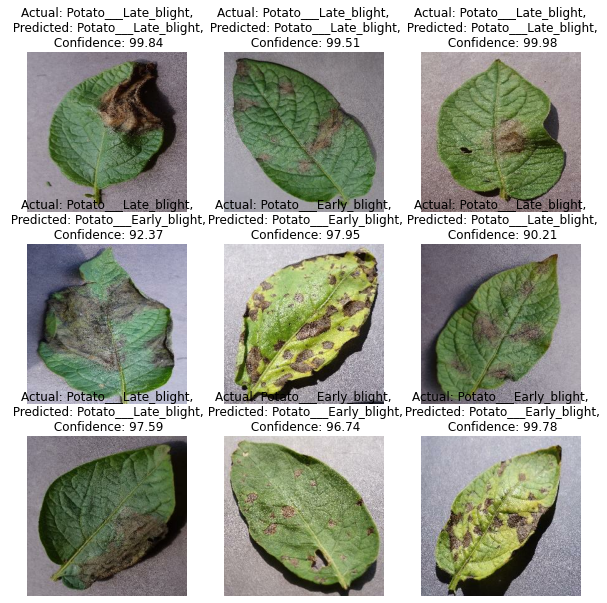

In [121]:
plt.figure(figsize = (10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        
        predicted_class , confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        
                   

In [122]:
import os
model_version = max([int(i) for i in os.listdir("../models")+[0]]) +1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets
